# Mode-Turbulence Coupling: Numerical Analysis
# M = 10^4, < Delta_tau > = 2pi, K = 1, eta M^2 = 0.0125
# Plot <A^2>^{1/2}_deltaTau vs. Tau

In [7]:
import matplotlib.pyplot as plt
import numpy as np
import math
import scipy.interpolate as interpolate

n_bins = 200

axis_font = {'size':'30'}
title_font = {'size':'40'}

In [8]:
# ## Physical Parameters

# eta * Ma ^2 = 0.0125
Ma = 0.0125 ** (1/2)
K = 1
eta = 1


# ## Functions of Ma

meandeltaT = np.pi

# variables for generating F2, H and G1
stdF2 = eta * Ma**2
limitY2 = eta 


# ## Calculation parameters

L = 1
M = 10**4
N = 1
m = 10**2
D = 0.001

J = 300
dTau = meandeltaT / J

Tr = K * meandeltaT

# ## Initial Conditions

initial_AT = 0
initial_dAdT = 0

In [12]:
# ## Functions

# deltaT
def fundeltaT(n_bins, M, dTau):
    deltaT = []
    
    # generate a rayleigh distribution from which to pick values for deltaT from
    rayleigh = np.random.rayleigh(meandeltaT, M)                           
    hist, bin_edges = np.histogram(rayleigh, bins=n_bins, density=True)
    cum_values = np.zeros(bin_edges.shape)
    cum_values[1:] = np.cumsum(hist*np.diff(bin_edges))
    inv_cdf = interpolate.interp1d(cum_values, bin_edges)
    
    for i in range(M):
        # picks a random value from the rayleigh distribution
        r = np.random.rand(1)
        deltaTtemp = inv_cdf(r)
        
        # rounds deltaTtemp up or down to be an interger multiple of dTau
        if (deltaTtemp % dTau < 0.005):
            deltaTtemp2 = deltaTtemp - (deltaTtemp % dTau)
        else:
            deltaTtemp2 = deltaTtemp + dTau - (deltaTtemp % dTau)
        deltaT.append(deltaTtemp2[0])
        
    return deltaT

# generating F2, G1
def funF_k(std, limit, deltaT):
    F_k =[]
    y1 = 0
    for i in range(len(deltaT) - 1):
        
        # Tn is halfway through the eddy
        Tn = ((deltaT[i] + deltaT[i+1]) / 2)
        
        stdevt = ((1 - math.exp(-2 * Tn / Tr)) * std ** 2) ** (1/2)
        meant = math.exp(-Tn / Tr) * y1
        
        # y1 is chosen from markov conditional probability function
        # put limit on y1
            # set y1 > limitY1 so that while loop only ends when y1 < limitY1
        y1 = limit + 1
        while abs(y1) > limit:
            y1 = np.random.normal(meant, stdevt, 2)[0]
        
        # loops through each eddy
        for j in np.linspace(0, deltaT[i], int(deltaT[i] / dTau)):
            x = j / deltaT[i]
            if j == deltaT[i]:
                pass
            else:
                F_k.append(16 * y1 * x**2 * (1 - x)**2)
        
    return F_k

# generating F1
def fundHdt(std, limit, deltaT):
    dHdt =[]
    y1 = 0
    for i in range(len(deltaT) - 1):
        
        # Tn is halfway through the eddy
        Tn = ((deltaT[i] + deltaT[i+1]) / 2)
        
        stdevt = ((1 - math.exp(-2 * Tn / Tr)) * std ** 2) ** (1/2)
        meant = math.exp(-Tn / Tr) * y1
        
        # y1 is chosen from markov conditional probability function
        # put limit on y1
            # set y1 > limitY1 so that while loop only ends when y1 < limitY1
        y1 = limit + 1
        while abs(y1) > limit:
            y1 = np.random.normal(meant, stdevt, 2)[0]
        
        # loops through each eddy
        for j in np.linspace(0, deltaT[i], int(deltaT[i] / dTau)):
            x = j / deltaT[i]
            if j == deltaT[i]:
                pass
            else:
                # calculated the derivative of H = 16 * y1 * x**2 * (1 - x)**2
                dHdt.append(1 / deltaT[i] * 32 * y1 * x * (2 * x**2 - 3 * x + 1))
        
    return dHdt

def funAmp(F1, F2, G1, dTau, A, dAdt):
    # huen's method
    # u = dA/dt
    
    Amp = [A]
    t = 0.0
    amptime = [t]
    u = dAdt
    
    for i in range(0, int(len(F1)) -2):
        m1 = u
        k1 = -((D + F1[i]) * u ) - ( 1 + G1[i] ) * A + F2[i]
        m2 = u + dTau * k1
        A_2 = A + dTau * m1
        u_2 = m2
        k2 = -((D + F1[i + 1]) * u_2 ) - ( 1 + G1[i + 1] ) * A_2 + F2[i + 1]
        m2 = u + dTau * k2
        t = t + dTau
        A = A + (dTau / 2) * (m1 + m2)
        u = u + (dTau / 2) * (k1 + k2)
        Amp.append(A)
        amptime.append(t)
    
    Amp = Amp[:-1]
    amptime = amptime[:-1]
    nextAmp = Amp[-1]
    
    return Amp, amptime, nextAmp, u

# Root mean square
def FunRMS(A):
    RMS = np.sqrt(np.mean(np.array(A)**2))
    return RMS

def plotRMS(RMS, Tau):
    plt.plot(Tau, RMS, 'k')
    plt.title(r'RMS vs. $\tau$')
    plt.xlabel(r'$\tau$')
    plt.ylabel('RMS(A)')
    plt.tight_layout
    plt.show()
    
def FunplotAmp(amptime, Amp):
    plt.figure(figsize=(40,10))
    plt.plot(amptime, Amp, 'k')
    plt.title('Amplitude of the Mode', **title_font)
    plt.xticks(fontsize=30)
    plt.yticks(fontsize=30)
    plt.xlabel(r'$\tau$', **axis_font)
    plt.ylabel('Amplitude', **axis_font)
    plt.tight_layout()
    plt.show()

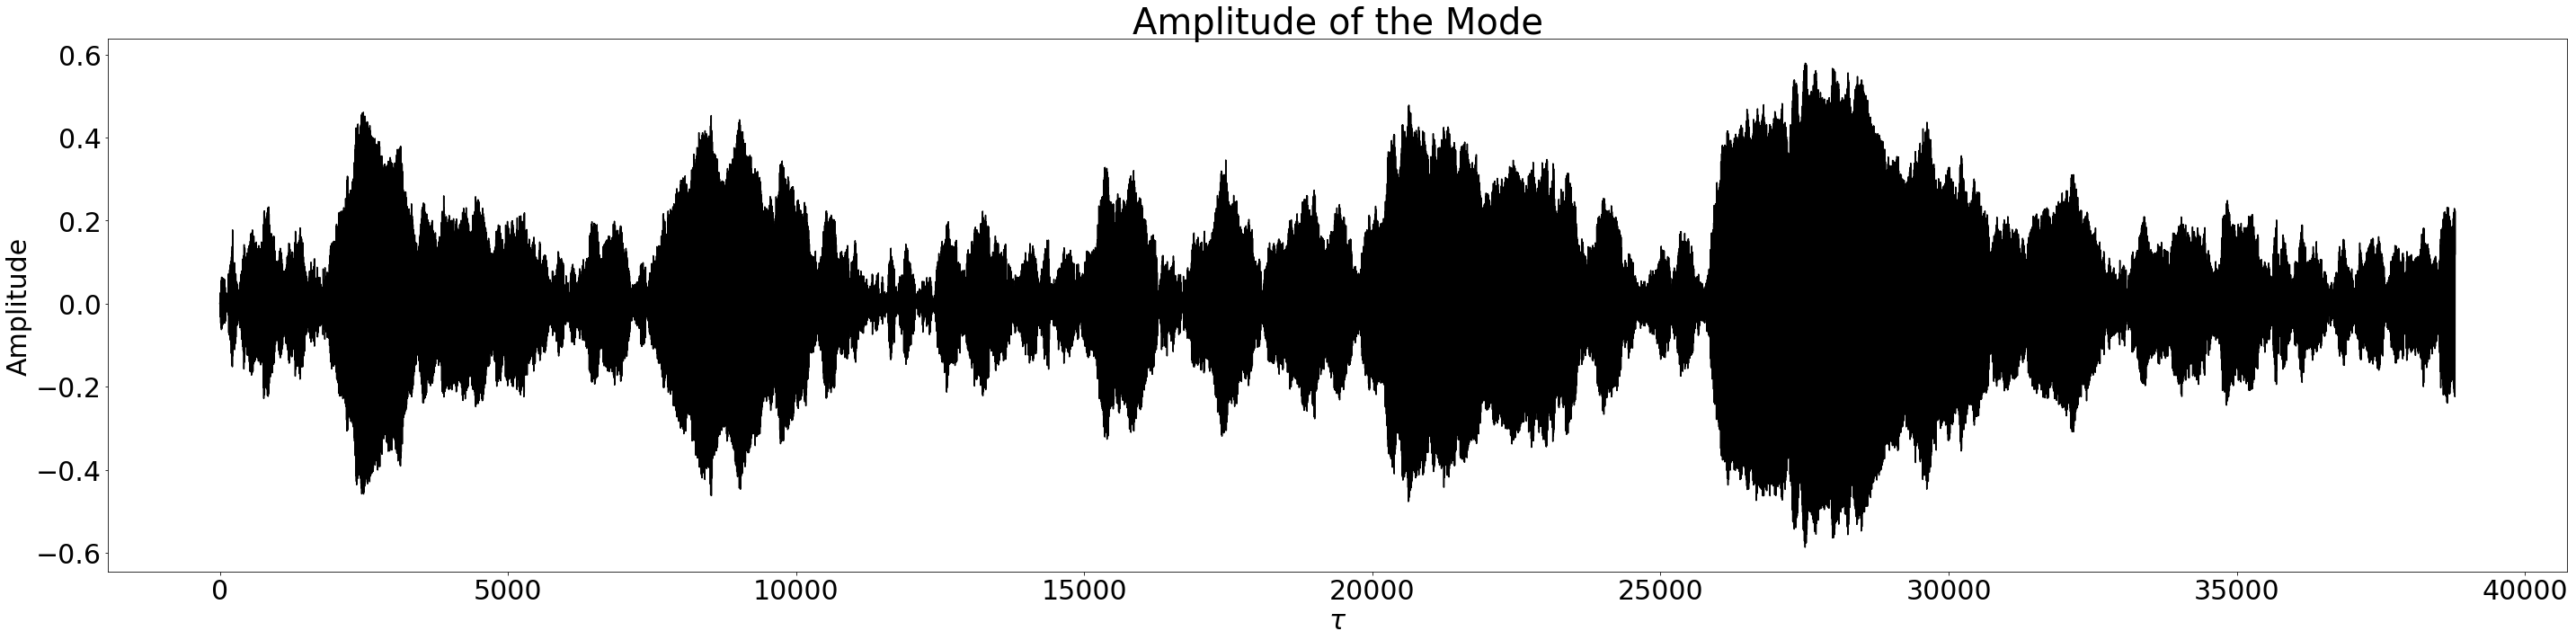

In [13]:
# deltaT is the length of each eddy turnover
deltaT = fundeltaT(n_bins, M, dTau)

# generate F1, F2, G1
F2 = funF_k(stdF2, limitY2, deltaT)
G1 = funF_k(stdF2, limitY2, deltaT)
F1 = fundHdt(stdF2, limitY2, deltaT)

# generate amp and corresponding time
Amp, amptime, nextAmp, nextdAdt = funAmp(F1, F2, G1, dTau, initial_AT, initial_dAdT)

FunplotAmp(amptime, Amp)

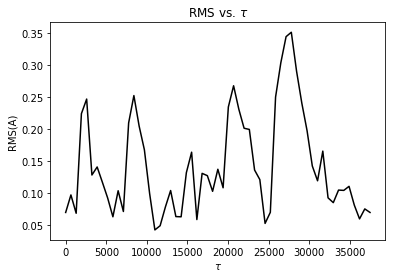

In [14]:
deltaM = 0.01 * M
deltaTau = 2 * np.pi * deltaM

Tau = np.linspace(0, amptime[-1], int(amptime[-1]/deltaTau))

# add two values for indexing reasons
np.append(Tau, Tau[-1] + deltaTau)
np.append(Tau, Tau[-1] + deltaTau)

# separate amp into segments corresponding to amp_deltaTau
index = 0
tot_amp = []
for i in range(len(Tau)-2):
    cur_amp = []
    while (amptime[index] <= Tau[i+1]) and (amptime[index] >= Tau[i]):
        cur_amp.append(Amp[index])
        index += 1
    tot_amp.append(cur_amp)

# remove last two extraneously added values
Tau = Tau[0:len(Tau)-2]

# calculate RMS of each segment to obtain RMS(A)_deltaTau
RMS_tot = []
for amp in tot_amp:
    RMS_tot.append(FunRMS(amp)) 

plotRMS(RMS_tot, Tau)